### Convolutional Neural Network 

In [25]:
import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from torchvision.utils import make_grid

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
plt.style.use('seaborn-white')
import warnings 
warnings.filterwarnings('ignore','DeprecatedWarnings')

In [26]:
torch.__version__

'1.7.1'

### Loading Datasets 

In [27]:
# MNIST Is considered to be the Hello World of CNN's and Deep Learning in General, so it is 
# generally provided from as the inbuild go-to project for beginners 
transforms = transforms.ToTensor()
train_data = datasets.MNIST(root='../Data', train=True, download=True, transform=transforms)
test_data = datasets.MNIST(root='../Data', train=False, download=True, transform=transforms)

In [28]:
train_data 

Dataset MNIST
    Number of datapoints: 60000
    Root location: ../Data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [29]:
test_data 

Dataset MNIST
    Number of datapoints: 10000
    Root location: ../Data
    Split: Test
    StandardTransform
Transform: ToTensor()

### Data Loader Object

In [30]:
# Pytorch's convention to create dataloader objects, to be used in the models train cycle 
batch_s = 10
train_loader = DataLoader(train_data,batch_size=batch_s,shuffle=True)
test_loader = DataLoader(test_data,batch_size=batch_s,shuffle=False) 

### What is the Data about? 

In [31]:
# pipeline obj=1/
desc = '''
The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.
'''
print(desc)


The MNIST database of handwritten digits, available from this page, has a training set of 60,000 examples, and a test set of 10,000 examples. It is a subset of a larger set available from NIST. The digits have been size-normalized and centered in a fixed-size image.



In [32]:
(x_train, y_train) = train_data[0] # one sample

In [33]:
y_train # label

5

Text(0.5, 1.0, 'label 5')

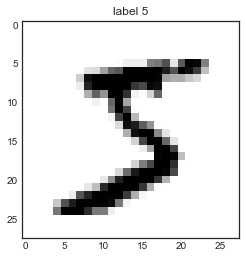

In [34]:
plt.imshow(x_train[0],cmap='binary')
plt.title('label {}'.format(y_train))

### Convolutional Neural Network Class

### Buidling Model 

In [35]:
class convolutional(nn.Module):
    
    def __init__(self,in_channel=1,output=10): 
        super().__init__() # inheriting nn.Module
        # defining Layer Functions 
        # input dimension = (b,28,28,1)
        self.conv1 = nn.Conv2d(in_channels=in_channel, out_channels=6, kernel_size=(3,3), stride=1 )
        # (b,26,26,6)
        self.pool = nn.MaxPool2d(kernel_size=(2,2), stride=(2,2)) # f=2, s=2 
        #  dimension (b,12,12,6)
        self.conv2 = nn.Conv2d(in_channels=6,out_channels=16,kernel_size=(3,3),stride=1)
        # dimension (b,10,10,16)
        # we apply one more pool after this dimension so (b,5,5,16)
        self.fc1 = nn.Linear(5*5*16,120)
        self.fc2 = nn.Linear(120, 64)
        self.fc3 = nn.Linear(in_features=64,out_features=output)

    def forward(self,X):
        # Construction of the Architecture 
        X = F.relu(self.conv1(X))
        X = self.pool(X)
        X = F.relu(self.conv2(X))
        X = self.pool(X)
        X = X.view(-1, 5*5*16) # Flatten
        X = F.relu(self.fc1(X))
        X = F.relu(self.fc2(X))
        X = self.fc3(X)
        return F.log_softmax(X, dim=1)
    
    
        
        


In [36]:
net = convolutional()

In [37]:
net

convolutional(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=10, bias=True)
)

In [38]:
print('Total Learnable Params :')
params = [p.numel() for p in net.parameters() if p.requires_grad]
for item in params:
    print(f'{item:>10}')
print(f'___________\n{sum(params):>10}')

Total Learnable Params :
        54
         6
       864
        16
     48000
       120
      7680
        64
       640
        10
___________
     57454


In [39]:
# defining the loss function and optimizer 
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(net.parameters(),lr=0.001)

In [40]:
# The TRAIN CYCLE 
import time 
start = time.perf_counter()
# trackers, for post evaluation
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []
accuracy = []

for i in range(epochs):
    trn_corr = 0
    tst_corr = 0
    
    # Run the training batches
    for b, (X_train, y_train) in enumerate(train_loader):
        b+=1
        
        # Apply the model
        y_pred = net(X_train)  # we don't flatten X-train here
        loss = criterion(y_pred, y_train)
 
        # Tally the number of correct predictions
        _, predicted = y_pred.max(1)
        batch_corr = (predicted == y_train).sum()
        trn_corr += batch_corr
        
        # Update parameters
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        # Print interim results
        if b%600 == 0:
            print(f'epoch: {i:2}  batch: {b:4} [{10*b:6}/60000]  loss: {loss.item():10.8f}  \
accuracy: {trn_corr.item()*100/(10*b):7.3f}%')
            accuracy.append(trn_corr.item()*100/(10*b))
        
    train_losses.append(loss)
    train_correct.append(trn_corr)
        
    # Run the testing batches
    with torch.no_grad():
        for b, (X_test, y_test) in enumerate(test_loader):

            # Apply the model
            y_val = net(X_test)

            # Tally the number of correct predictions
            predicted = torch.max(y_val.data, 1)[1] 
            tst_corr += (predicted == y_test).sum()
            
    loss = criterion(y_val, y_test)
    test_losses.append(loss)
    test_correct.append(tst_corr)
    
elapsed = (time.perf_counter() - start)/60
print('ELAPSED {:.2f}'.format(elapsed))
        


epoch:  0  batch:  600 [  6000/60000]  loss: 0.13196187  accuracy:  77.617%
epoch:  0  batch: 1200 [ 12000/60000]  loss: 0.01571199  accuracy:  85.200%
epoch:  0  batch: 1800 [ 18000/60000]  loss: 0.39610186  accuracy:  88.583%
epoch:  0  batch: 2400 [ 24000/60000]  loss: 0.02174448  accuracy:  90.396%
epoch:  0  batch: 3000 [ 30000/60000]  loss: 0.28220776  accuracy:  91.537%
epoch:  0  batch: 3600 [ 36000/60000]  loss: 0.00760804  accuracy:  92.372%
epoch:  0  batch: 4200 [ 42000/60000]  loss: 0.00093206  accuracy:  93.000%
epoch:  0  batch: 4800 [ 48000/60000]  loss: 0.22920069  accuracy:  93.556%
epoch:  0  batch: 5400 [ 54000/60000]  loss: 0.13263322  accuracy:  93.974%
epoch:  0  batch: 6000 [ 60000/60000]  loss: 0.00078909  accuracy:  94.302%
epoch:  1  batch:  600 [  6000/60000]  loss: 0.01727303  accuracy:  97.633%
epoch:  1  batch: 1200 [ 12000/60000]  loss: 0.00111780  accuracy:  97.700%
epoch:  1  batch: 1800 [ 18000/60000]  loss: 0.14143839  accuracy:  97.778%
epoch:  1  b

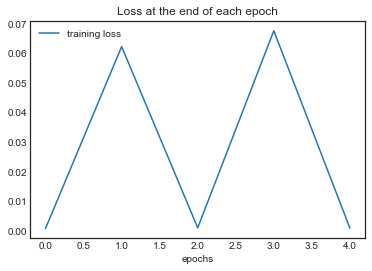

In [41]:
plt.plot(train_losses, label='training loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('epochs')
plt.legend();

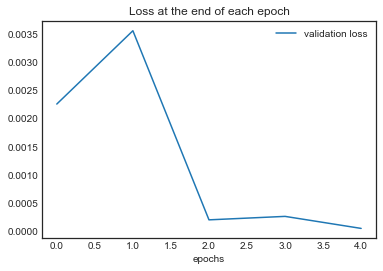

In [42]:
plt.plot(test_losses, label='validation loss')
plt.title('Loss at the end of each epoch')
plt.xlabel('epochs')
plt.legend();

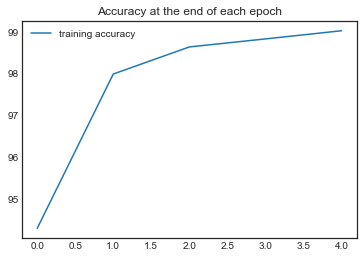

In [43]:
plt.plot([t/600 for t in train_correct], label='training accuracy')

plt.title('Accuracy at the end of each epoch')
plt.legend();

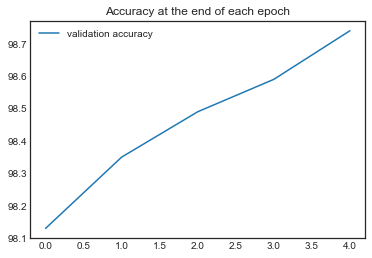

In [44]:
plt.plot([t/100 for t in test_correct], label='validation accuracy')
plt.title('Accuracy at the end of each epoch')
plt.legend();

### Overall Evaluation

In [45]:
test_load = DataLoader(test_data,batch_size=10000, shuffle=False)

In [46]:
with torch.no_grad():
    correct = 0
    for x_test, y_test in test_load:
        y_val = net(x_test)
        _, predicted = y_val.max(1)
        correct += (predicted == y_test).sum()
        
print(f'Test accuracy: {correct.item()}/{len(test_data)} = {correct.item()*100/(len(test_data)):7.3f}%')

Test accuracy: 9874/10000 =  98.740%


In [47]:
predicted

tensor([7, 2, 1,  ..., 4, 5, 6])

In [78]:
# Classification Report
class_report = classification_report(y_test,predicted)
print(class_report)

              precision    recall  f1-score   support

           0       0.98      1.00      0.99       980
           1       1.00      0.99      0.99      1135
           2       0.99      0.99      0.99      1032
           3       0.99      0.98      0.99      1010
           4       0.99      0.99      0.99       982
           5       0.99      0.98      0.99       892
           6       0.99      0.98      0.99       958
           7       0.98      0.99      0.99      1028
           8       0.99      0.97      0.98       974
           9       0.97      1.00      0.98      1009

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000



In [48]:
# Missed Pictures and their indexes
misses = np.array([])

for i in range(len(predicted.view(-1))):
    
    if predicted[i] != y_test[i]:
        misses = np.append(misses,i).astype('int64')
    
misses

array([ 158,  321,  326,  340,  435,  445,  495,  582,  659,  716,  740,
        938,  947, 1014, 1021, 1032, 1033, 1062, 1182, 1226, 1242, 1319,
       1393, 1425, 1530, 1641, 1681, 1773, 1782, 1790, 1878, 1901, 2018,
       2035, 2070, 2109, 2118, 2130, 2182, 2195, 2462, 2597, 2654, 2771,
       2896, 2921, 2927, 2939, 2953, 3073, 3225, 3289, 3333, 3422, 3448,
       3490, 3520, 3558, 3662, 3726, 3727, 3762, 3767, 3778, 3796, 3893,
       3906, 3951, 4007, 4075, 4163, 4176, 4256, 4265, 4359, 4360, 4382,
       4497, 4507, 4551, 4620, 4639, 4731, 4807, 4823, 4860, 4956, 4978,
       5176, 5265, 5734, 5877, 5887, 5937, 5955, 5973, 5997, 6023, 6093,
       6555, 6572, 6576, 6597, 6603, 6625, 6847, 7928, 8094, 8156, 8326,
       8408, 8520, 8527, 9636, 9642, 9664, 9679, 9729, 9770, 9777, 9839,
       9888, 9904, 9922, 9976, 9982])

### Single Image Test

Text(0.5, 1.0, 'Label 3')

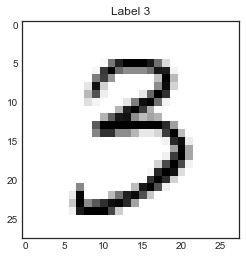

In [49]:
index = 2020
plt.figure(figsize=(4,4))
plt.imshow(x_test[index].reshape(28,28),cmap='binary')
plt.title('Label {}'.format(y_test[2020]))

In [50]:
net.eval()
with torch.no_grad():
    yhat = net(x_test[index][0].view(1,1,28,28))
    print('Prediction ~ {}'.format(yhat.argmax()))
    print('Reality - {}'.format(y_test[index]))

Prediction ~ 3
Reality - 3


### Miscellaneous

In [51]:
# PipeLine Script Data  

In [108]:
desc = desc.strip()
project_name = 'MNIST'
framework = 'Pytorch'
prediction_type = 'Classification'
network_type = 'Convolutional Neural Network'
architecture = str(net)
layers = 6
hidden_units = None 
activations = "['relu','softmax']"
epochs = 5
metrics = 'Accuracy'
train_accuracy = np.mean(accuracy)
test_accuracy = 98.720
classification_report = class_report
elapsed = '2.48 Min'
plots = './Projects/MNIST/Pytorch/Plots'
ipynb = './Projects/MNIST/Pytorch/MNIST-Pytorch.pdf'

In [109]:
param = dict()
var_dict = {}
var = ['desc','project_name', 'framework','prediction_type','network_type',
       'architecture','layers','hidden_units','activations','epochs',
       'metrics','train_accuracy','test_accuracy','classification_report','elapsed'
       ,'ipynb','plots']

for i in var:
    var_dict[i] = input(f'Enter Dtype for {i}: ')



Enter Dtype for desc: string
Enter Dtype for project_name: string
Enter Dtype for framework: string
Enter Dtype for prediction_type: string
Enter Dtype for network_type: string
Enter Dtype for architecture: string
Enter Dtype for layers: int
Enter Dtype for hidden_units: int
Enter Dtype for activations: string(list)
Enter Dtype for epochs: int
Enter Dtype for metrics: string
Enter Dtype for train_accuracy: float%
Enter Dtype for test_accuracy: float%
Enter Dtype for classification_report: string
Enter Dtype for elapsed: float
Enter Dtype for ipynb: path
Enter Dtype for plots: path


In [110]:
var_dict

{'desc': 'string',
 'project_name': 'string',
 'framework': 'string',
 'prediction_type': 'string',
 'network_type': 'string',
 'architecture': 'string',
 'layers': 'int',
 'hidden_units': 'int',
 'activations': 'string(list)',
 'epochs': 'int',
 'metrics': 'string',
 'train_accuracy': 'float%',
 'test_accuracy': 'float%',
 'classification_report': 'string',
 'elapsed': 'float',
 'ipynb': 'path',
 'plots': 'path'}

In [111]:
with open('../../var-dict.txt','wb') as f:
    pickle.dump(var_dict,f)

In [112]:
! ls ../../

MNIST                   pipeline.py
PipeLine Testing .ipynb var-dict.txt


In [113]:
for val in var:
    param[val] = eval(val)

In [114]:
import pickle
file = open("artefacts.txt", "wb") 
  
dictionary = param 
pickle.dump(dictionary, file) 
file.close() 


In [57]:
import pandas as pd
pd.DataFrame(pd.Series(param)).T

,project_name,framework,prediction_type,network_type,Architecture,layers,hidden_units,Activations,epochs,metrics,Train_Accuracy,Test_Accuracy,elapsed,Desc
0,MNIST,Pytorch,Classification,Convolutional Neural Network,"convolutional(\n (conv1): Conv2d(1, 6, kernel...",6,None,"['relu','softmax']",5,Accuracy,96.9026,98.72,2.48 Min,"The MNIST database of handwritten digits, avai..."


In [58]:
! pwd

/Users/Shared/Relocated/Security/Code/Deep_Learning/DeepLearning-Conjunction/Git/Dev/Projects/MNIST/Pytorch


In [59]:
import os 
string = '/Users/Shared/Relocated/Security/Code/Deep_Learning/DeepLearning-Conjunction/Git/Dev/Projects/MNIST/Pytorch'.split('/')
os.path.join('./',*string[-3:])

'./Projects/MNIST/Pytorch'

In [60]:
import pickle
prompt_list = ['Network Type : ','Prediction Type : ', 'Network Architecture : ', 'Number of Layers : ', 
'Number of Hidden Units :', 'Activations Used : ', 'Number of Epochs : ', 'Metrics: ',
'Train and Test Accuracy : ', 'Elapsed Time for Training : '] 
f_pl = open('../../../prompt-list.txt','wb')

pickle.dump(prompt_list, f_pl)
f_pl.close()


In [61]:
! ls ../../../

Micellaneous         catalog.csv          prompt-list.txt
Projects             deep-learning.png    tesseract.png
README.md            dynamic-prompt.py
catalog-test.numbers main.py


In [62]:
prompt_list

['Network Type : ',
 'Prediction Type : ',
 'Network Architecture : ',
 'Number of Layers : ',
 'Number of Hidden Units :',
 'Activations Used : ',
 'Number of Epochs : ',
 'Metrics: ',
 'Train and Test Accuracy : ',
 'Elapsed Time for Training : ']

In [63]:
# with open(, 'rb') as f:
#     data = f.read()
# test_list = pickle.load(data)
# test_list

with open('../../../prompt-list.txt', 'rb') as f:
    
    data = f.read() 
        

d = pickle.loads(data) 

In [64]:
d

['Network Type : ',
 'Prediction Type : ',
 'Network Architecture : ',
 'Number of Layers : ',
 'Number of Hidden Units :',
 'Activations Used : ',
 'Number of Epochs : ',
 'Metrics: ',
 'Train and Test Accuracy : ',
 'Elapsed Time for Training : ']